# Task 3 Python

### Text based clustering (NLP) : Perform unsupervised topic modelling of unlabeled text descriptions

In [55]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stops = set(stopwords.words("english"))
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import re
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
plot_size = plt.rcParams["figure.figsize"] 
plot_size[0] = 15
plot_size[1] = 5
plt.rcParams["figure.figsize"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\css120804\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\css120804\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[15, 5]

In [21]:
data=pd.read_excel("../Data/DocumentsData.xlsx")

In [22]:
data.head()

,Id,Doc Name
0,1,"Nozzle, 220542"
1,2,Value Collection 15 Inch Long x 12 Inch Wide x...
2,3,Made in USA 18 Inch Long x 13 Inch Wide x 4 mi...
3,4,"8""W x 10""L 4mil Clear Reclosable Bag"
4,5,Value Collection 12 Inch Long x 9 Inch Wide x ...


# a. Perform preprocessing and cleaning  text data 

In [47]:
def remove_stop_words(data):
    """Remove stop words"""
    stop_words = stops
    words = map(str.lower,word_tokenize(str(data)))# tockenization and lowercasing the text
    new_text = ""
    for w in words:
        if w not in stop_words:
            new_text = new_text + " " + w
    return new_text

RemoveNumber = lambda elem: re.sub(r"\d+", " ", elem)  ## removing number

def remove_punctuation(data):
    """Remove punctuation"""
    symbols = r"!\"#$%&()*+-./:;<=>?@[\]^`{|}~\_'"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], " ")
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ",", " ")
    return str(data)

wordLengthRestrictionLemma = lambda x,y: " ".join([wordnet_lemmatizer.lemmatize(w.lower()) for w in x.split(" ") if len(w) > y]) # Word length restriction and lemmatization


def initial_clean(data,res=2):
    """ Basic preprocessing """
    data = remove_punctuation(data)
    data = remove_stop_words(data)
    data = RemoveNumber(data)
    data = wordLengthRestrictionLemma(data,res)
    return data

def wordCount(sentense):
    """ Count the number of wordsin sentence """
    count=len(sentense.split())
    return(count)

In [28]:
data.columns

Index(['Id', 'Doc Name'], dtype='object')

In [29]:
data["Processed"]=data["Doc Name"].progress_apply(initial_clean)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 111.11it/s]


In [48]:
data["wordcount"]=data["Processed"].progress_apply(wordCount)

100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 118994.10it/s]


In [49]:
data.head()

,Id,Doc Name,Processed,wordcount
0,1,"Nozzle, 220542",nozzle,1
1,2,Value Collection 15 Inch Long x 12 Inch Wide x...,value collection inch long inch wide mil thick...,13
2,3,Made in USA 18 Inch Long x 13 Inch Wide x 4 mi...,made usa inch long inch wide mil thick ziplock...,14
3,4,"8""W x 10""L 4mil Clear Reclosable Bag",mil clear reclosable bag,4
4,5,Value Collection 12 Inch Long x 9 Inch Wide x ...,value collection inch long inch wide mil thick...,13


In [36]:
data.shape

(500, 3)

In [50]:
df=data[data.wordcount>0]

In [51]:
df.shape

(499, 4)

# b. Execute feature engineering method to extract text features (use TF-IDF)

In [53]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2,ngram_range=(1,3))
X = vect.fit_transform(df.Processed)

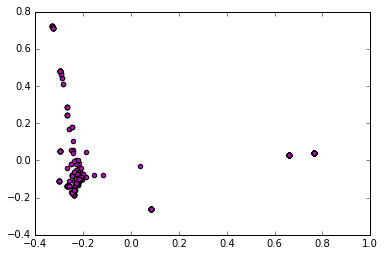

In [56]:
from sklearn.decomposition import PCA
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [57]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [58]:
import numpy as np
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

                features     score
0                   inch  0.266367
1                polybag  0.199688
2  value collection inch  0.199688
3  ziplock polybag heavy  0.199688
4        ziplock polybag  0.199688
5        collection inch  0.199688
6    mil ziplock polybag  0.199688
7   collection inch long  0.199688
8     polybag heavy duty  0.199688
9          polybag heavy  0.199688


In [59]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [60]:
print(top_mean_feats(X, features, top_n=10))

             features     score
0               drill  0.057546
1              jobber  0.056932
2               split  0.056874
3        cobalt split  0.056829
4  cobalt split point  0.056829
5         split point  0.056829
6              cobalt  0.056829
7        jobber drill  0.056829
8                gold  0.056466
9    split point gold  0.055033


# c. Run topic modelling clustering algorithm to label text descriptions with proper category

C:\Users\css120804\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\css120804\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\css120804\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "
C:\Users\css120804\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_dista

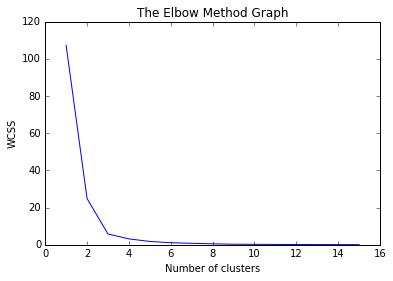

In [70]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,16):
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 ,n_jobs=3, precompute_distances='auto',verbose=0)
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,16),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [73]:
kmeans = KMeans(n_clusters=4, init ='k-means++', max_iter=300, n_init=15,random_state=0 )
y_kmeans = kmeans.fit_predict(coords)
cluster_labels = kmeans.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
final_result=pd.concat([data, cluster_labels], axis=1)

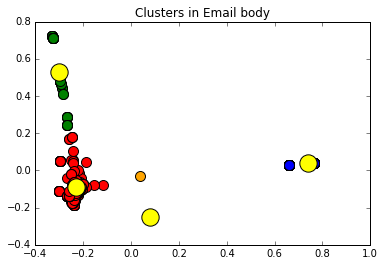

In [77]:
plt.scatter(coords[y_kmeans==0, 0], coords[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(coords[y_kmeans==1, 0], coords[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(coords[y_kmeans==2, 0], coords[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(coords[y_kmeans==3, 0], coords[y_kmeans==3, 1], s=100, c='orange', label ='Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters in Email body')
plt.show()

# Provided data can be divided into 4 clusters

In [79]:
from sklearn.cluster import KMeans
n_clusters = 4
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

In [80]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [81]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

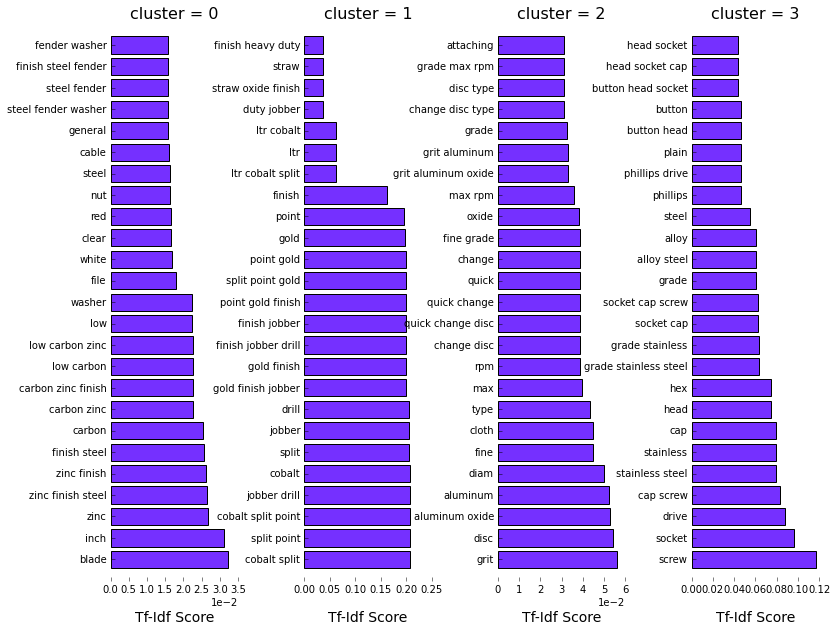

In [82]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

# The End